**Table of contents**<a id='toc0_'></a>    
- 1. [Imports](#toc1_)    
- 2. [Model class](#toc2_)    
  - 2.1. [Basic Edgeworth box](#toc2_1_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1. <a id='toc1_'></a>[Imports](#toc0_)

In [98]:
import matplotlib.pyplot as plt

# Use latex rendering for nice plot
plt.rcParams.update({
    "axes.grid": True,
    "grid.color": "black",
    "grid.alpha": "0.25",
    "grid.linestyle": "--",
    "font.size": 14,
})


%load_ext autoreload
%autoreload 2

import numpy as np
# Set seed number
np.random.seed(404)
from scipy import optimize

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2. <a id='toc2_'></a>[Model class](#toc0_)

In [99]:
from ExchangeEconomy import ExchangeEconomyClass

### 2.1. <a id='toc2_1_'></a>[Basic Edgeworth box](#toc0_)

In [100]:
model = ExchangeEconomyClass()

1. Illustrating the set in a Edgeworth box

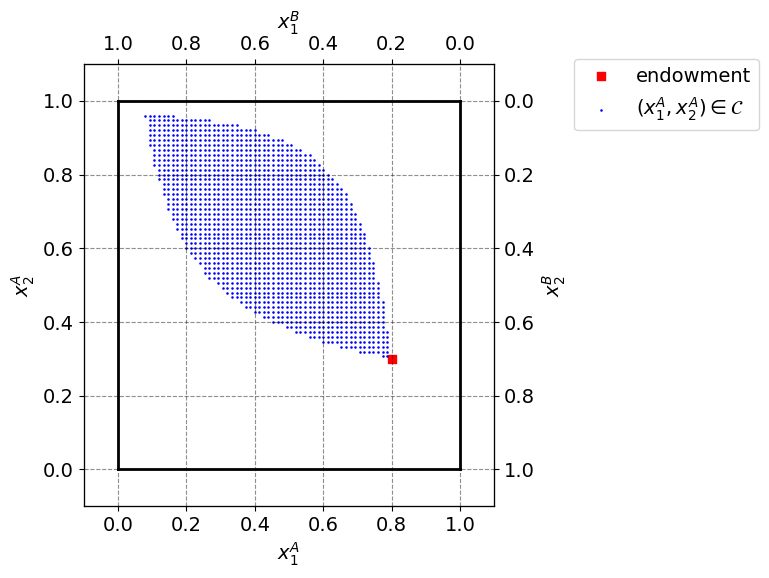

In [101]:
par = model.par

# a. total endowment
w1bar = 1.0
w2bar = 1.0

# b. figure set up
fig = plt.figure(figsize=(6,6),tight_layout=True)
ax_A = fig.add_subplot(1, 1, 1)

ax_A.set_xlabel("$x_1^A$")
ax_A.set_ylabel("$x_2^A$")

temp = ax_A.twinx()
temp.set_ylabel("$x_2^B$")
ax_B = temp.twiny()
ax_B.set_xlabel("$x_1^B$")
ax_B.invert_xaxis()
ax_B.invert_yaxis()

# A
ax_A.scatter(par.w1A,par.w2A,marker='s',color='r',label='endowment')

# Initial endowments
omega_a1 = par.w1A
omega_a2 = par.w2A
omega_b1 = 1-par.w1A
omega_b2 = 1-par.w2A

# Generate point grids
N = 75
x_a1 = np.linspace(0,1,N+1)
x_a2 = np.linspace(0,1,N+1)

# Define the set C
C = [
    (xA1, xA2) for xA1 in x_a1 for xA2 in x_a2 
    if model.utility_A(xA1, xA2) >= model.utility_A(omega_a1, omega_a2) 
    and model.utility_B(1 - xA1, 1 - xA2) >= model.utility_B(omega_b1, omega_b2)
]

# Plot C
ax_A.scatter([point[0] for point in C], [point[1] for point in C], marker='o', color='b', label=r'$(x_1^A, x_2^A) \in \mathcal{C}$', s=0.7)

# limits
ax_A.plot([0,w1bar],[0,0],lw=2,color='black')
ax_A.plot([0,w1bar],[w2bar,w2bar],lw=2,color='black')
ax_A.plot([0,0],[0,w2bar],lw=2,color='black')
ax_A.plot([w1bar,w1bar],[0,w2bar],lw=2,color='black')

ax_A.set_xlim([-0.1, w1bar + 0.1])
ax_A.set_ylim([-0.1, w2bar + 0.1])    
ax_B.set_xlim([w1bar + 0.1, -0.1])
ax_B.set_ylim([w2bar + 0.1, -0.1])

fig.legend(loc='upper right',bbox_to_anchor=(1.3,.9))

2. Calculate error in market clearing condition

In [102]:
P_1 = np.linspace(0.5,2.5,N+1)
eps_1,eps_2=model.market_clear_err(P_1)

# Use python-built in functions to find the minimum absolute error 
# Make sure they are the same across A/B (or very close to)
min_err1=abs(eps_1).min()
min_err2=abs(eps_2).min()
assert min_err1-min_err2<=1e-3

market_clearing_p=model.find_eq(P_1)

In [103]:
# Make larger linspace with smaller space to find (analytical) solution
P_1_analytical = np.linspace(0.5,2.5,20000)
market_clearing_p_analytical=model.find_eq(P_1_analytical)
eps_1_ana,eps_2_ana=model.market_clear_err(P_1_analytical)
min_err_analytical=abs(eps_1_ana).min()

Market clearing price p_1 in P_1 is 0.9533 with error 0.0053
"Analytical" market clearing price is 0.9444 with error 0.0


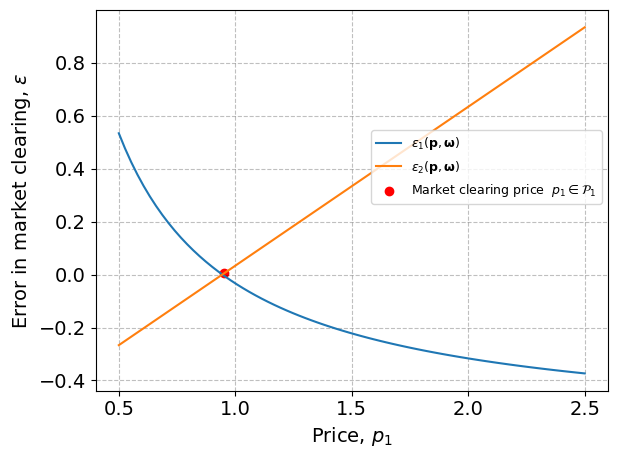

In [104]:
fig,ax = plt.subplots(tight_layout=True)
ax.plot(P_1, eps_1, label=r'$\epsilon_1(\mathbf{p}, \mathbf{\omega})$')
ax.plot(P_1, eps_2, label=r'$\epsilon_2(\mathbf{p}, \mathbf{\omega})$')
ax.scatter(market_clearing_p, min_err2, color='r', label=r'Market clearing price  $p_1 \in \mathcal{P}_1$')
ax.set_ylabel(r'Error in market clearing, $\epsilon$')
ax.set_xlabel(r'Price, $p_1$')
ax.legend(loc='upper right', bbox_to_anchor=(1,.7), fontsize=9)
print(f'Market clearing price p_1 in P_1 is {market_clearing_p.round(4)} with error {min_err2.round(4)}')
print(f'"Analytical" market clearing price is {market_clearing_p_analytical.round(4)} with error {min_err_analytical.round(4)}')

4a. Finding the allocation if only prices in $\mathcal{P_1}$ can be chosen, assuming that A chooses the price:

In [105]:
# Price vector
P_1 = np.linspace(0.5,2.5,N+1)

## Define objective function
def obj_max_U(p1):
    x_b1, x_b2=model.demand_B(p1)
    return -model.utility_A(1-x_b1, 1-x_b2)

initial_price_guess = 1

# Bounds defined as belonging to P
bounds = [(P_1.min(), P_1.max())]

# Minimize the negative utility
res = optimize.minimize(obj_max_U, initial_price_guess, bounds=bounds)

# Price that maximizes utility for A
price_util_max_a=round(res.x[0], 3)
utility_val_A=round(-res.fun, 3)

# Corresponding allocation
x_b1_opt,x_b2_opt=model.demand_B(price_util_max_a)
x_a1_opt = 1-x_b1_opt
x_a2_opt = 1-x_b2_opt

x_a1_opt,x_a2_opt, x_b1_opt,x_b2_opt = round(x_a1_opt, 3), round(x_a2_opt, 3), round(x_b1_opt, 3), round(x_b2_opt, 3)

# Summing up
print(f'Price in P_1 that maximizes As utility: {price_util_max_a} with utility {utility_val_A} \n This gives the allocation: \n X1A={x_a1_opt}\n X2A= {x_a2_opt}\n X1B={x_b1_opt}\n X2B={x_b2_opt}')

# Lets plot it
x1bs, x2bs = model.demand_B(P_1)
uAs = model.utility_A(1-x1bs, 1-x2bs)

Price in P_1 that maximizes As utility: 1.899 with utility 0.634 
 This gives the allocation: 
 X1A=0.621
 X2A= 0.64
 X1B=0.379
 X2B=0.36


4b. Finding the allocation if any positive price can be chosen

In [106]:
# Bounds now positive
bounds = [(0, None)]

# Minimize the negative utility
res = optimize.minimize(obj_max_U, initial_price_guess, bounds=bounds)

# Price that maximizes utility for A
price_util_max_a=round(res.x[0], 3)
utility_val_A=round(-res.fun, 3)

# Corresponding allocation
x_b1_opt,x_b2_opt=model.demand_B(price_util_max_a)
x_a1_opt = 1-x_b1_opt
x_a2_opt = 1-x_b2_opt

x_a1_opt,x_a2_opt, x_b1_opt,x_b2_opt = round(x_a1_opt, 3), round(x_a2_opt, 3), round(x_b1_opt, 3), round(x_b2_opt, 3)

# Summing up
print(f'Any postive price that maximizes As utility:  {price_util_max_a} with utility {utility_val_A} \n This gives the allocation: \n X1A={x_a1_opt}\n X2A= {x_a2_opt}\n X1B={x_b1_opt}\n X2B={x_b2_opt}')

Any postive price that maximizes As utility:  1.899 with utility 0.634 
 This gives the allocation: 
 X1A=0.621
 X2A= 0.64
 X1B=0.379
 X2B=0.36


We notice that this is the same price!

---

5a. Finding the allocation if the choice set is restricted to $\mathcal{C}$.

In [93]:
# Define the bounds from C
x_a1_min = min([point[0] for point in C])
x_a1_max = max([point[0] for point in C])
x_a2_min = min([point[1] for point in C])
x_a2_max = max([point[1] for point in C])

def obj_max_U(X):
    return -model.utility_A(X[0], X[1])

# Get me a random pair of xa1s and xa2s from C
id_rand=np.random.randint(0,N)
guess=C[id_rand]

# Minimize the negative utility
res = optimize.minimize(obj_max_U, x0=guess,bounds=((x_a1_min,x_a1_max), (x_a2_min,x_a2_max)))
res

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: -0.8983475852802386
        x: [ 7.867e-01  9.600e-01]
      nit: 1
      jac: [-3.807e-01 -6.239e-01]
     nfev: 6
     njev: 2
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

5b. Finding the allocation if no further restrictions are imposed (?) 
- Different interpretation: Must be better off than what is endowed, but not in $\mathcal{C}$. Let's call it $\mathcal{D}$.

In [ ]:
# Generate point grids
N = 75
x_a1 = np.linspace(0,1,N+1)
x_a2 = np.linspace(0,1,N+1)

In [96]:
# Define the set D
D = [
    (xA1, xA2) for xA1 in x_a1 for xA2 in x_a2 
    if model.utility_B(1-xA1, 1-xA2) >= model.utility_B(omega_b1, omega_b2)
]

# Making sure that B's utility is not lower than in the initial endowment
def constraint(x):
    return model.utility_B(1 - x[0], 1 - x[1]) - model.utility_B(model.par.w1A, model.par.w2A)

# Redefine objective function
def obj_max_U(x):
    return -model.utility_A(x[0], x[1])

# Get me a random pair of xa1s and xa2s from D
id_rand=np.random.randint(0,N)
guess=D[id_rand]

# Minimize the negative utility
res = optimize.minimize(obj_max_U, x0=guess,bounds=((0,1), (0,1)),constraints={'type': 'ineq', 'fun': constraint})
res

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.48082247168999065
       x: [ 2.895e-01  6.197e-01]
     nit: 22
     jac: [-5.537e-01 -5.173e-01]
    nfev: 76
    njev: 22

6a. Finding the social planner allocation that maximizes aggregate utility

In [107]:
# Define the set D
D = [
    (xA1, xA2) for xA1 in x_a1 for xA2 in x_a2 
    if model.utility_B(1-xA1, 1-xA2) >= model.utility_B(omega_b1, omega_b2)
]

# Redefine objective function
def obj_max_U(x):
    return -(model.utility_A(x[0], x[1]) + model.utility_B(1-x[0], 1-x[1]))

# Get me a random pair of xa1s and xa2s from D
id_rand=np.random.randint(0,N)
guess=D[id_rand]

# Minimize the negative utility (no constraints)
res = optimize.minimize(obj_max_U, x0=guess,bounds=((0,1), (0,1)))
res

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: -1.058267367957499
        x: [ 3.333e-01  6.667e-01]
      nit: 22
      jac: [-7.194e-06  4.485e-06]
     nfev: 105
     njev: 35
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

7/8. Drawing a random set $\mathcal{W}$

In [ ]:
# Defining the set as "W", cause it looks like a W 
# This is to distinguish between omegas

omega_1a = np.randnorm()
omega_1b

W = [
    ()
]